<a href="https://colab.research.google.com/github/hui509/titanic_analysis/blob/main/%E5%B0%88%E9%A1%8C%E5%AF%A6%E4%BD%9C%EF%BD%9C09_%E9%90%B5%E9%81%94%E5%B0%BC%E8%99%9F%E5%AD%98%E6%B4%BB%E9%A0%90%E6%B8%AC_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 專題實作 #09 鐵達尼號存活預測_Version 1

# **載入Titanic資料集的 `train.csv` 資料集**
（資料網址：https://raw.githubusercontent.com/dsindy/kaggle-titanic/master/data/train.csv）

In [322]:
import pandas as pd
url = 'https://raw.githubusercontent.com/dsindy/kaggle-titanic/master/data/train.csv'
df = pd.read_csv(url)

# **資料概況**

1. Titanic 各欄位的定義
* PassengerId：乘客ID
* Survived：生存狀態（0=No，1=Yes）  
* Pclass：艙等 （1=1st, 2=2nd, 3=3rd）
* Name：姓名  
* Sex：性別  
* Age：年紀
* SibSp：兄弟姐妹/配偶的数量
* Parch：父母/子女的数量
* Ticket：船票號碼
* Fare：船票價格
* Cabin：艙位號碼
* Embarked：登船港口（C=Cherbourg,　Q=Queenstown,　S=Southampton）




2. 基本資料

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df.isnull().sum()

# **資料探索與分析 (EDA)**

**1. 初步發現：排除 Name、Sex、Ticket、Cabin、Embarked 五項非數值資料下，**
**可見「Fare」與「Survived」的正相關性最高**


In [ ]:
# 使用 Pearson 係數計算相關性
cor = df.corr()

In [ ]:
# 使用seaborn和matplotlib，視覺化呈現相關性
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(cor,annot=True,linewidth=0.5,cmap='coolwarm')
plt.title('Correlation Matrix of Titanic')
plt.show()

**2. 進階討論：低票價的乘客，存活機會較低**



In [328]:
# 定義distribution函數，以KDE圖觀察欄位與Survived之間的關係

def distribution(df,var,target,**kwargs):
  # 設定row和col參數
  row = kwargs.get('row',None)
  col = kwargs.get('col',None)

  # 使用seaborn函數製圖
  facet = sns.FacetGrid(df,row=row,col=col,hue=target,aspect=3)
  facet.map(sns.kdeplot,var,fill=True)
  facet.set(xlim=(0,df[var].max()))
  facet.add_legend()

In [ ]:
# 觀察Fare和Survived的關係
distribution(df,var='Fare',target='Survived')
plt.show()

**2. 其他發現：**

*   **Age 中，15歲以下的少年存活機率較高**
*   **Sex 中，女性乘客的存活機會高於男性**
*   **Pclass 中，一等艙的乘客有較高的存活機會**
*   **Embarked 中，從 Cherbourg 登船者的存活機會較高**



In [ ]:
# 觀察Age和Survived的關係
distribution(df,var='Age',target='Survived')
plt.show()

In [331]:
# 定義categories函數，以長條圖觀察欄位與Survived之間的關係

def categories(df,cat,target,**kwargs):
  # 設定row和col參數
  row = kwargs.get('row',None)
  col = kwargs.get('col',None)

  # 使用seaborn函數製圖
  facet = sns.FacetGrid(df,row=row,col=col,height=4)
  facet.map(sns.barplot,cat,target,color='lightblue')
  facet.add_legend()

In [ ]:
# 觀察Sex和Survived的關係
categories(df,cat='Sex',target='Survived')
plt.show()

In [ ]:
# 觀察Pclass和Survived的關係
categories(df,cat='Pclass',target='Survived')
plt.show()

In [ ]:
# 觀察Embarked和Survived的關係
categories(df,cat='Embarked',target='Survived')
plt.show()

# **資料清理與型態轉換**

1. 刪除多餘的欄位
* PassengerId：僅用以辨識乘客，無關生存
* Name：危機時期，比較不可能出現唱名救援
* Ticket：船票編號僅代表購買順序或核對資訊
* Cabin：欄位中的缺失值(687)佔全體(891)中的77%


In [335]:
titanic = df.copy()
titanic.drop(columns=['PassengerId','Name','Ticket','Cabin'],axis=1,inplace=True)

2. 轉換類別欄位：Sex、Embarked
* LabelEncoder：因欄位資料並非有序類別，故不考慮使用
* OneHotEncoder：拆分Embarked為「Embarked_C、Embarked_Q、Embarked_S」


In [336]:
# Sex直接轉換
titanic['Sex'] = titanic['Sex'].replace({'male':1,'female':0})

# Embarked使用OneHotEncoder
titanic = pd.get_dummies(titanic,columns=['Embarked'],dtype=int)

# **資料缺失值處理**

In [337]:
# 以平均數填補 Age 欄位的缺失
titanic['Age'].fillna(titanic['Age'].mean(),inplace=True)

# **特徵工程**

1. **船上親屬人數的多寡，是否會影響生存機會？**

In [ ]:
#新增FamilySize欄位統整乘客在船上的親屬人數
df['FamilySize'] = df['SibSp']+df['Parch']+1

#使用distribution函數，以KDE圖觀察與Survived之間的關係
distribution(df,var='FamilySize',target='Survived')
plt.show()

In [339]:
# 定義family函數，將親屬人數進行分類
def family(size):
  if size == 1:
    return 'Single'
  elif 2<=size<=4:
    return 'Small'
  else:
    return 'Large'

# 新增Family_Type說明所屬分類：單身、小家庭、大家庭
df['Family_Type'] = df['FamilySize'].map(family)

In [340]:
# 使用OneHotEncoder轉換類別欄位並join數據
df_Family_ohe = pd.get_dummies(df['Family_Type'], prefix='Family_')
titanic = titanic.join(df_Family_ohe)

2. **乘客頭銜隱含社會地位，是否會影響生存機會？**



In [341]:
# 定義extraction函數，抽取乘客頭銜
def extraction(name):
  title = name.split(',')[1].split('.')[0].strip()
  return title

# 新增Raw Title欄位放置抽取出的乘客頭銜
df['Raw Title'] = df['Name'].map(extraction)

In [342]:
# 觀察Name中頭銜的種類
title_set = set()
for name in df['Name']:
  title_set.add(extraction(name))

# 製作title對應的dictionary

title_dict = {
'Col':      'Officer',
'Major':     'Officer',
'Capt':      'Officer',
'Jonkheer':    'Royalty',
'Don':      'Royalty',
'Dona':      'Royalty',
'Sir':      'Royalty',
'the Countess': 'Royalty',
'Lady':      'Royalty',
'Dr':       'Royalty',
'Rev':      'Royalty',
'Mr':       'Mr',
'Ms':       'Ms',
'Miss':      'Miss',
'Mlle':      'Miss',
'Mrs':       'Mrs',
'Mme':       'Mrs',
'Master':     'Master'
}

# 新增Title欄位放置經轉換的頭銜
df['Title'] = df['Raw Title'].map(title_dict)

In [ ]:
# #使用categories函數，以長條圖觀察Title與Survived的關係
categories(df,cat='Title',target='Survived')
plt.show()

In [344]:
# 使用OneHotEncoder轉換類別欄位並join數據
df_Title_ohe = pd.get_dummies(df['Title'], prefix='Title_')
titanic = titanic.join(df_Title_ohe)

# **模型分析**

1. 採用 scikit-learn 五種基本模型進行分析與比較
2. 使用 sklearn.model_selection 下的 GridSearchCV( )調整參數

* **邏輯回歸 Logistic Regression**
* **支持向量機 Support Vector Machines**
* **決策樹 Decision Tree Classifier**
* **隨機森林 Random Forest Classifier**
* **K-近鄰演算法 K Nearest Neighbor**


In [345]:
# 載入模型
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [346]:
# 定義特徵欄位X、目標欄位Y，並完成訓練集資料
columns_X = set(titanic.columns) - {'Survived'}
columns_y = ['Survived']
train_X = titanic[list(columns_X)]
train_y = titanic[columns_y]

# 依不同模型進行基本分析
models = {
    'Logistic Regression':LogisticRegression(random_state=0,max_iter=3000),
    'SVM':SVC(),
    'Decision Tree Classifer':DecisionTreeClassifier(),
    'Random Forest Classifer':RandomForestClassifier(),
    'KNN':KNeighborsClassifier()
      }

scores = [ ]
for model_name,model in models.items():
  score = cross_val_score(model,train_X,train_y.values.ravel(),cv=5,scoring='accuracy').mean()
  scores.append({'model':model_name, 'accuracy':score})

In [ ]:
# 分析並優化超參數調整流程
from sklearn.model_selection import GridSearchCV
model_params = {
  'Logistic Regression(Opt)':{
      'model':LogisticRegression(),
      'params':{'C': [0.01, 0.1, 1, 10],'solver': ['liblinear','lbfgs']}
              },
  'SVM(Opt)':{
      'model':SVC(),
      'params':{'C':[0.1,1,10],'kernel':['rbf'],'gamma':[0.05, 0.1]}
      },
  'Decision Tree Classifier(Opt)':{
      'model':DecisionTreeClassifier(),
      'params':{'criterion': ['gini', 'entropy'],'max_depth': [4, 6, 8],
            'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4]}
          },
  'Random Forest Classifier(Opt)':{
      'model':RandomForestClassifier(),
      'params':{'n_estimators': [10, 50],'max_depth': [4, 6, 8],'min_samples_split': [2, 5, 10],
           'min_samples_leaf': [1, 2, 4],'max_features': ['auto', 'sqrt']}
          },
  'KNN(Opt)':{
      'model':KNeighborsClassifier(),
      'params':{'n_neighbors': [3, 5, 7, 9],'weights': ['uniform', 'distance']}
      }
  }

scores_opt = []

for model_name, mp in model_params.items():
  clf = GridSearchCV(mp['model'],mp['params'],cv=5)
  score = cross_val_score(mp['model'],train_X,train_y.values.ravel(),cv=5,scoring='accuracy').mean()
  scores_opt.append({'model':model_name,'accuracy':score})

In [ ]:
# 輸出結果
combined = scores + scores_opt
df = pd.DataFrame(combined)
df.sort_values(by='accuracy',ascending=False)

3. 使用PyTorch、TensorFlow模型進行分析

In [349]:
# 切割訓練集、測驗集
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_X,train_y,test_size=0.2)

In [350]:
# TensorFlow
import tensorflow as tf
y_train_onehot = tf.keras.utils.to_categorical(y_train,num_classes=2)
y_test_onehot = tf.keras.utils.to_categorical(y_test,num_classes=2)

In [ ]:
# PyTorch
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

# 創建模型架構
class Model(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.hidden1 = torch.nn.Linear(input_size, hidden_size)
        self.hidden2 = torch.nn.Linear(hidden_size, hidden_size)
        self.predict = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        output1 = self.hidden1(x)
        output2 = self.hidden2(output1)
        output = F.softmax(self.predict(output2))
        return output

# 模型、優化器初始化
model = Model(X_test.shape[1], 32, 2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.0) # 模型參數優化器
loss_func = torch.nn.CrossEntropyLoss()

# 資料格式轉成torch專用格式
x_data = torch.tensor(X_train.values, dtype=torch.float32) # [120, 4]
y_data = torch.tensor(y_train_onehot, dtype=torch.float32) # [120, 3]
x_test_data = torch.tensor(X_test.values, dtype=torch.float32) # [120, 4]
y_test_data = torch.tensor(y_test_onehot, dtype=torch.float32) # [120, 3]

batch_size = 16
num_epochs = 100
num_batches = len(X_train) // batch_size
loss_list = []
test_loss_list = []

for epoch in range(num_epochs):
    for i in range(num_batches):
        start = i * batch_size
        end = start + batch_size
        prediction = model(x_data[start:end])
        loss = loss_func(prediction, y_data[start:end])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss = loss_func(model(x_data), y_data)
    loss_list.append(loss.item())

    test_loss = loss_func(model(x_test_data), y_test_data)
    test_loss_list.append(test_loss.item())

print(loss_list)
print(test_loss_list)

Text(0, 0.5, 'BCE Loss')

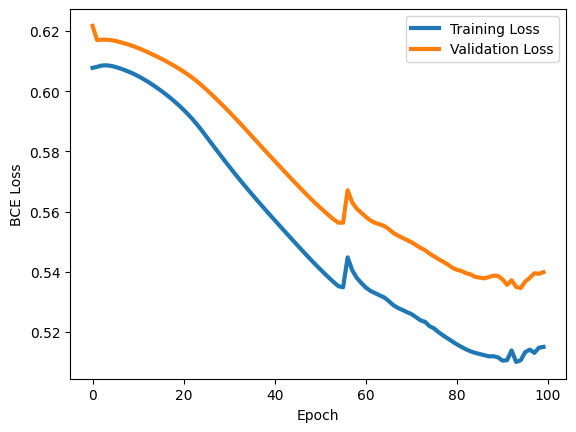

In [352]:
# 視覺化呈現結果
import matplotlib.pyplot as plt
plt.plot(loss_list, linewidth=3)
plt.plot(test_loss_list, linewidth=3)
plt.legend(('Training Loss','Validation Loss'))
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')

In [ ]:
# 輸出結果
x_test_data = torch.tensor(X_test.values, dtype=torch.float32)
y_pred = model(x_test_data)
y_pred = y_pred.argmax(1) # one hot array to int array
pytorch_accuracy = accuracy_score(y_test, y_pred.detach().numpy())

In [354]:
# 合併其他模型數據結果
pyt = pd.DataFrame({'model':['PyTorch'],'accuracy':[pytorch_accuracy]})
df = pd.concat([df,pyt],axis=0)
df.sort_values(by='accuracy',ascending=False)

,model,accuracy
5,Logistic Regression(Opt),0.824901
0,Logistic Regression,0.823784
3,Random Forest Classifer,0.805857
8,Random Forest Classifier(Opt),0.800226
7,Decision Tree Classifier(Opt),0.763172
2,Decision Tree Classifer,0.759814
0,PyTorch,0.748603
4,KNN,0.716101
9,KNN(Opt),0.716101
1,SVM,0.675733


# **結論：**

## **1. 資料探索與分析 (EDA)**
* Fare中，低票價的乘客，存活機會較低
* Age 中，15歲以下的少年存活機率較高
* Sex 中，女性乘客的存活機會高於男性
* Pclass 中，一等艙的乘客有較高的存活機會
* Embarked 中，從 Cherbourg 登船者的存活機會較高

## **2. 特徵工程**
* 船上親屬人數的多寡，是否會影響生存機會？
  * Accuracy 約為0.8，提升約2%
  * 船上無親屬時，可能獨自成功逃生，但也可能不被注意而死亡
  * 船上親屬人數在2-4人的情況，存活機會較高
  * 船上親屬人數超過5人的情況，存活機會較低

* 乘客頭銜隱含社會地位，是否會影響生存機會？
  * Accuracy 約為0.82，再提升約2%
  * 具備女性稱謂者，生存機會較高

## **3. 模型分析**
* Logistic Regression 的 Accuracy 位居首位，約為0.82
* 多數模型準確度些微提升，但整體而言參數調整的影響不大
* PyTorch 的結果與其他模型相比，位居中位
